# RNN: Implementation From Scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Utils import *
from RNN import *

# Data Preprocessing

1.  **Tokenization**: To break down the raw text into individual words or units (tokens).

2.  **Vocabulary Construction**: To establish a defined set of known words, filtering out infrequent ones and adding a special token (`<UNK>`) for unknown words encountered later.

3.  **Indexing**: To assign a unique numerical ID to every word in the vocabulary for computational use.

4.  **Sequence Generation**: To transform the text into sequences of numerical IDs and create corresponding input ($X$) and target ($Y$) sequences needed for training the model to predict the next word.

5.  **Numerical Representation (One-Hot Encoding)**: To convert each word's numerical ID into a sparse vector format ($[0, ..., 1, ..., 0]$) suitable as input for the neural network.

In [7]:
# Prepare Data
corpus_text = """
Recurrent Neural Networks, or RNNs, are a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, or numerical times series data.
Unlike feedforward neural networks, RNNs use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.
The term Recurrent Neural Network is used generically to refer to two broad classes of networks with a similar general structure, where one is finite impulse and the other is infinite impulse. Both classes of networks exhibit temporal dynamic behavior. A finite impulse recurrent network is a directed acyclic graph that can be unrolled and replaced with a strictly feedforward neural network, while an infinite impulse recurrent network is a directed cyclic graph that cannot be unrolled.
"""

# Prepare word-level data
X_one_hot_data, Y_data, word_to_ix, ix_to_word, vocab_size = prepare_word_data_onehot(
    corpus_text,
    vocab_threshold=1
)
if not X_one_hot_data: sys.exit("Data preparation failed.")

Preparing word data (one-hot inputs)...
Total words found: 140
Vocabulary size (threshold>=1): 85
Using entire text as one sequence.
Prepared 1 training sequence(s).


# RNN Implementation

## Model Architecture

This implementation utilizes a standard Recurrent Neural Network (RNN). The network processes sequential data one time step at a time, maintaining an internal hidden state that captures information from previous steps.

The key components are:

1.  **Input Layer**: One-hot vector $x_t \in \{0, 1\}^V$ at each time step $t$, where $V$ is the vocabulary size.
2.  **Hidden Layer**: Computes the hidden state $h_t \in \mathbb{R}^{D_h}$ using the current input $x_t$ and the previous hidden state $h_{t-1}$. $D_h$ represents the dimensionality of the hidden state.:

    $$
    h_t = \tanh(W_{hh} h_{t-1} + W_{hx} x_t + b_h) \in \mathbb{R}^{D_h}
    $$
    
    Where:
    *   $W_{hx} \in \mathbb{R}^{D_h \times V}$: Weight matrix connecting input to hidden layer.
    *   $W_{hh} \in \mathbb{R}^{D_h \times D_h}$: Weight matrix connecting the previous hidden state to the current hidden state (Recurrent Connection).
    *   $b_h \in \mathbb{R}^{D_h \times 1}$: Bias vector for the hidden layer.
    
3.  **Output Layer**: Produces a probability distribution over the vocabulary for the next word prediction $\hat{y}_t \in \mathbb{R}^V$.
    $$
    \hat{y}_t = \text{softmax}(W_{hy} h_t + b_y)
    $$
    
    Where:
    *   $W_{hy} \in \mathbb{R}^{V \times D_h}$: Weight matrix connecting the hidden layer to the output layer.
    *   $b_y \in \mathbb{R}^{V \times 1}$: Bias vector for the output layer.

The initial hidden state $h_0$ is typically initialized as a zero vector.

## Loss Function

*   **Cross-Entropy Loss:** The cross-entropy loss $L_t$ for a single time step $t$ is defined as:

$$ L_t(y^{(t)}, \hat{y}^{(t)}) = - \sum_{i=1}^{V} y_i^{(t)} \log(\hat{y}_i^{(t)}) = - \log(\hat{y}_c^{(t)}) $$

Where:
* $c$: Index of the true class at time step $t$ (i.e., $y_c^{(t)} = 1$).
* $\hat{y}^{(t)} \in \mathbb{R}^V$: Output of RNN, a probability distribution  over the vocabulary using the `softmax` activation function.
* $y^{(t)} \in \mathbb{R}^V$: True target represented as one-hot vector, where the element corresponding to the correct next word/character index is 1 and all other elements are 0.

For a sequence of length $T$:
$$ L_{total} = \frac{1}{T} \sum_{t=1}^{T} L_t = -\frac{1}{T} \sum_{t=1}^{T} \sum_{i=1}^{V} y_i^{(t)} \log(\hat{y}_i^{(t)}) $$

## Activation Function

*   **Tanh (Hyperbolic Tangent):** In every hidden states:
    $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

*   **Softmax:** Convert the raw output scores (logits) into a probability distribution over the vocabulary:
    $$ p_i = \sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}} $$

## Forward Pass

The forward pass computes the hidden states and output predictions sequentially through time for an input sequence $X = (x_1, x_2, ..., x_T)$ (One-hot vectors).

Starting with an initial hidden state $h_0$. For $t = 1, 2, ..., T$:
1.  Hidden Pre-activation:
    $$a_t = W_{hh} h_{t-1} + W_{hx} x_t + b_h$$
2.  Hidden State:
    $$h_t = \tanh(a_t)$$
3.  Output Logits:
    $$z_t = W_{hy} h_t + b_y$$
4.  Output Probabilities:
    $$\hat{y}_t = \text{softmax}(z_t)$$

During the forward pass, intermediate values ($x_t$, $h_t$, $\hat{y}_t$) are stored in a `cache` for use during the backward pass.

## Backward Pass

**Step 1: Gradient w.r.t. Output Logits ($\boldsymbol{\delta}_{z,t}$)**
$$
\boldsymbol{\delta}_{z,t} = \frac{\partial L}{\partial \mathbf{z}_t} = \frac{\partial L_t}{\partial \mathbf{z}_t} = \hat{\mathbf{y}}_t - \mathbf{y}_t \in \mathbb{R}^{V \times 1}
$$

**Step 2: Gradients for Output Layer Parameters ($\mathbf{W}_{hy}, \mathbf{b}_y$)**

*   **Gradient w.r.t. $\mathbf{b}_y$:**
    $$
    \frac{\partial L}{\partial \mathbf{b}_y} = \sum_{t = 1}^T\frac{\partial \mathbf{z}_t}{\partial \mathbf{b}_y} \frac{\partial L^{(t)}}{\partial \mathbf{z}_t} = \sum_{t = 1}^T\boldsymbol{\delta}_{z,t} \in \mathbb{R}^{V \times 1}
    $$

*   **Gradient w.r.t. $\mathbf{W}_{hy}$:**
    $$
    \frac{\partial L}{\partial \mathbf{W}_{hy}} = \sum_{t = 1}^T\frac{\partial \mathbf{z}_t}{\partial \mathbf{W}_{hy}}\frac{\partial L^{(t)}}{\partial \mathbf{z}_t} = \sum_{t = 1}^T\boldsymbol{\delta}_{z,t} \mathbf{h}_t^T \in \mathbb{R}^{(V \times D_h)}
    $$

**Step 3: Gradient w.r.t. Hidden State ($\boldsymbol{\delta}_{h,t}$)**

\begin{align*}
\boldsymbol{\delta}_{h,t} = \frac{\partial L}{\partial \mathbf{h}_t} &= \underbrace{\frac{\partial \mathbf{z}_t}{\partial \mathbf{h}_t} \frac{\partial L^{(t)}}{\partial \mathbf{z}_t}}_{\text{From output at } t} + \underbrace{\frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \frac{\partial L}{\partial \mathbf{h}_{t+1}}}_{\text{From hidden state at } t+1} \\
&= \mathbf{W}_{hy}^T \boldsymbol{\delta}_{z,t} + \mathbf{W}_{hh}^T \text{diag}(1 - \mathbf{h}_{t + 1}^2) \frac{\partial L}{\partial \mathbf{h}_{t+1}} \in \mathbb{R}^{D_h \times 1}
\end{align*}

**Step 4: Gradient w.r.t. Hidden Pre-activation ($\boldsymbol{\delta}_{a,t}$)**
$$
\boldsymbol{\delta}_{a,t} = \frac{\partial L}{\partial \mathbf{a}_t} = \frac{\partial \mathbf{h}_t}{\partial \mathbf{a}_t} \frac{\partial L}{\partial \mathbf{h}_t} = \text{diag}(1 - \mathbf{h}_t^2) \boldsymbol{\delta}_{h,t} = \boldsymbol{\delta}_{h,t} \odot (1 - \mathbf{h}_t^2) \in \mathbb{R}^{D_h \times 1}
$$

**Step 5: Gradients for Recurrent Layer Parameters ($\mathbf{W}_{hh}, \mathbf{W}_{hx}, \mathbf{b}_h$)**

*   **Gradient w.r.t. $\mathbf{b}_h$:**
    $$
    \frac{\partial L}{\partial \mathbf{b}_h} = \sum_{t = 1}^T\frac{\partial \mathbf{a}_t}{\partial \mathbf{b}_h} \frac{\partial L}{\partial \mathbf{a}_t} = \sum_{t = 1}^T\mathbf{I}^T \boldsymbol{\delta}_{a,t} = \sum_{t = 1}^T\boldsymbol{\delta}_{a,t} \in \mathbb{R}^{D_h \times 1}
    $$

*   **Gradient w.r.t. $\mathbf{W}_{hx}$:**
    $$
    \frac{\partial L}{\partial \mathbf{W}_{hx}} = \sum_{t = 1}^T  \frac{\partial \mathbf{a}_t}{\partial \mathbf{W}_{hx}} \frac{\partial L}{\partial \mathbf{a}_t} = \sum_{t = 1}^T\boldsymbol{\delta}_{a,t} \mathbf{x}_t^T \in \mathbb{R}^{D_h \times V}
    $$

*   **Gradient w.r.t. $\mathbf{W}_{hh}$:**
    $$
    \frac{\partial L}{\partial \mathbf{W}_{hh}} = \sum_{t = 1}^T  \frac{\partial \mathbf{a}_t}{\partial \mathbf{W}_{hh}} \frac{\partial L}{\partial \mathbf{a}_t} = \sum_{t = 1}^T \boldsymbol{\delta}_{a,t} \mathbf{h}_{t-1}^T \in \mathbb{R}^{D_h \times D_h}
    $$

**Step 6: Propagate Gradient to Previous Time Step**

Calculate the gradient component that needs to be passed back to the previous time step ($t-1$) to compute $\boldsymbol{\delta}_{h,t-1}$. This corresponds to the second term in Step 3's equation for $\boldsymbol{\delta}_{h,t-1}$:
$$
\text{Gradient from } t = \frac{\partial \mathbf{a}_{t}}{\partial \mathbf{h}_{t-1}} \frac{\partial L}{\partial \mathbf{a}_{t}} = \mathbf{W}_{hh}^T \boldsymbol{\delta}_{a,t}
$$

**Final Step: Gradient Clipping**

After the loop completes and all contributions are summed, gradient clipping is applied element-wise to each accumulated gradient matrix/vector ($\nabla \theta$) to prevent exploding gradients:
$$
\nabla \theta \leftarrow \text{clip}(\nabla \theta, -C, C)
$$

## Training

The model is trained using Stochastic Gradient Descent (SGD). Within each epoch:
1.  The training data, consisting of sequences of one-hot vectors $(X, Y)$, is iterated through.

2.  For each sequence:
    a.  The initial hidden state $h_0$ is reset (typically to zeros).

    b.  **Forward Pass**: The network computes predictions $\hat{Y} = (\hat{y}_1, ..., \hat{y}_T)$ and intermediate values (stored in `cache`) using the input sequence $X$ and the current parameters $\theta = (W_{hx}, W_{hh}, W_{hy}, b_h, b_y)$.

    c.  **Loss Calculation**: The average cross-entropy loss $L = \frac{1}{T} \sum_{t=1}^T L_t(\hat{y}_t, y_t)$ is computed for the sequence.

    d.  **Backward Pass**: BPTT is performed to calculate the gradients $\nabla_\theta L$ using the target sequence $Y$ and the `cache`. Gradient clipping may be applied.

    e.  **Parameter Update**: The model parameters are updated using the SGD rule:
        $\theta \leftarrow \theta - \eta \nabla_\theta L$
        where $\eta$ is the learning rate (`lr`).

The overall loss for the epoch is typically averaged over all sequences. The process is repeated for the specified number of epochs.


In [3]:
# Define Model Hyperparameters
hidden_dim = 100
learning_rate = 0.001
epochs = 1000
clip_value = 5
print_every = 50

In [4]:
# Instantiate Model
rnn_model = RNN(hidden_dim=hidden_dim, vocab_size=vocab_size)

# Set word mappings
rnn_model.word_to_ix = word_to_ix
rnn_model.ix_to_word = ix_to_word

Starting training (One-Hot Input) for 1000 epochs...
Learning rate: 0.001, Clipping: 5
Epoch 50/1000, Loss: 2.9962, Time: 0.02s

Generated examples:
  and neural networks recurrent to to a a of to neural
  where a a is a a a network of neural network
  where a a is a a a network of neural network

Epoch 100/1000, Loss: 1.1100, Time: 0.02s

Generated examples:
  impulse neural network is a a neural graph of can be
  inputs this a as to to a a one of or
  them of to with a as of artificial neural such or

Epoch 150/1000, Loss: 0.4289, Time: 0.02s

Generated examples:
  general neural networks or to are a type of artificial neural
  infinite impulse recurrent network is a directed acyclic graph that can
  designed neural network or rnns a a type of artificial neural

Epoch 200/1000, Loss: 0.2304, Time: 0.02s

Generated examples:
  dynamic neural networks or rnns are a type of artificial neural
  networks neural networks or to a a type of artificial neural
  can neural networks or rnns are

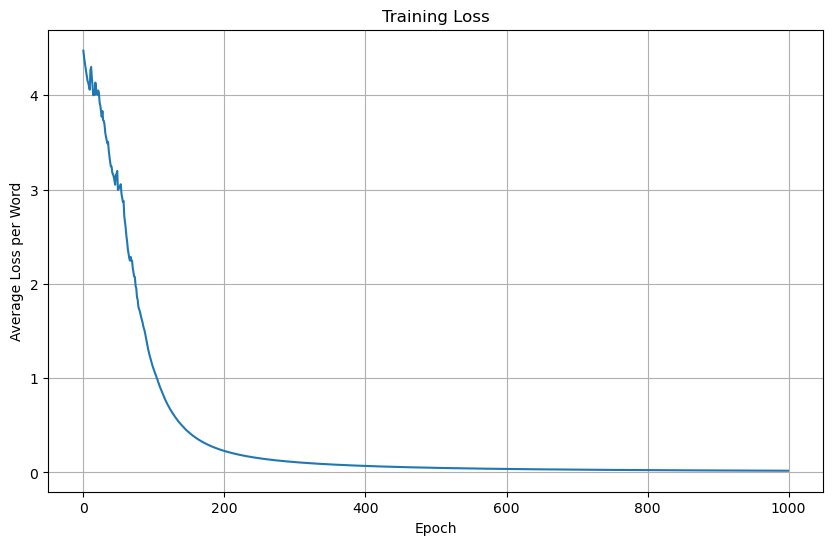

In [5]:
# Train Model
loss_history = rnn_model.train(
    X_one_hot_data, 
    Y_data,
    lr=learning_rate,
    epochs=epochs,
    clip_value=clip_value,
    print_every=print_every,
    generated_examples=3  # Show 3 examples per reporting interval
)

# Plot Loss
if loss_history:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss per Word")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

## Evaluation Metrics

1.  **Average Cross-Entropy Loss**: This is the primary quantitative metric tracked during training. It measures how well the model's predicted probability distributions align with the actual target words. Lower loss indicates better performance.

2.  **Text Generation**: The `sample_words` and `predict_words` functions allow for qualitative assessment by generating text sequences based on the trained model. Observing the coherence, grammar, and relevance of the generated text provides insight into the model's language modeling capabilities. Sampling strategies like 'random' (multinomial sampling) or 'argmax' (greedy selection) can be used.

In [6]:
# Evaluate by Sampling (Using the word-specific predict method)
print("\n--- Sampling from the trained model ---")
seed_word = "neural"
sample_length = 10

print(f"\nSampling (random choice) starting with '{seed_word}':")
sampled_text_random = rnn_model.predict_words(seed_word, n=sample_length, sample_strategy='random')
print(f"{sampled_text_random}")

print(f"\nSampling (argmax choice) starting with '{seed_word}':")
sampled_text_argmax = rnn_model.predict_words(seed_word, n=sample_length, sample_strategy='argmax')
print(f"{sampled_text_argmax}")


--- Sampling from the trained model ---

Sampling (random choice) starting with 'neural':
neural this or temporal a a unsegmented of neural networks designed

Sampling (argmax choice) starting with 'neural':
neural networks rnns rnns a a sequences of neural networks as
